In [1]:
### 前回からの修正点
# ・ゴニオデータの補完
# ・ゴニオ補間データの保存フォルダ．ファイル作成

In [2]:
import os
import csv
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy import signal
import cv2
from sklearn.metrics import r2_score
import pandas as pd
import math

In [3]:
##### データフォルダ・データシート作成（データフォルダが存在しない場合のみ実行）

data_folder = os.getcwd().replace(os.sep, "/") + "/Data"
datasheet_ver = 2
datasheet_path = data_folder + "/datasheet_ver" + str(datasheet_ver) + ".csv"
print("data_folder: " + data_folder)
print("datasheet: " + datasheet_path)

cols = ["No", "Gonio", "Echo", "Date", "Subject", "Pattern", "Additional Info", "Modified_Info", "Trial Num", "Depth", "Gain", "Focus", "Frequency", "Dynamic Range", 
        "Max Corners", "Quality Level", "Min Distance", "Block Size", "Trim Width", "Trim Height", "RMSE", "R2", "Corrcoef", "Updated Date"]

# データフォルダが存在しなければ作成
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print("Data folder was successfully created.")
else:
    print("Data folder already exists.")

# データシートが存在しなければ作成
if not os.path.exists(datasheet_path):
    df = pd.DataFrame(columns=cols)
    print(df)
    df.to_csv(datasheet_path, encoding="shift_jis", index=False)
    print("Datasheet was successfully created.")
    
    # csvモジュールでの新規書き込み
#     with open(datasheet_path, "w", newline="") as f:
#         writer = csv.writer(f)
#         writer.writerow(["", "INFO", "", "", "", "", "", "", "SOFT PARAM", "", "", "", "", "", "PATH", "", "", "RESULTS"])
#         writer.writerow(["No", "Date", "Subject", "Pattern", "Additional Info", "Modified_Info", "Trial Num", "", "Depth", "Gain", "Focus", "Frequency", "Dynamic Range", "", "Gonio", "Echo", "", "RMSE", "R2", "Corrcoef"])
    
else:
    print("Datasheet already exists.")

data_folder: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data
datasheet: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/datasheet_ver2.csv
Data folder already exists.
Datasheet already exists.


In [4]:
#   要修正

### ターゲットのデータがデータシートに既に記入されているか（一度同じ条件で解析されているか）を確認

data_sheet = pd.read_csv(datasheet_path, header=0, encoding='shift_jis')
# print(data_sheet)


In [5]:
#    要修正

### ターゲットのデータがなければデータシートに記入
# print(target_data_block.empty)
# if not target_data_block.empty:

In [6]:
#### ターゲットデータ取得（1個）

# データナンバー
##この値を変えると自動的に、実験日、被験者、実験パターン、試行No.を抽出する
# ※ 解析対象を変更するときは、この番号だけ変えればよい
data_No = 182
# 182 - 191

# target_data = data_sheet[ data_sheet['No']==data_No ]
target_data = data_sheet.loc[data_sheet.No == data_No].copy()
print('--target_data-----------')
print(target_data)
print('------------------------')


print('--target_data information--')
## INFO
# 実験日
date = str(int(target_data["Date"].iloc[0]))
print("date            : " + date)

# 被験者
subject = str(target_data["Subject"].iloc[0])
print("subject         : " + subject)

# 実験パターン
pattern = int(target_data['Pattern'].iloc[0])
print("pattern         : " + str(pattern))

# 補足
additional_info = str(target_data["Additional Info"].iloc[0])
if additional_info == "nan":
    additional_info = ""
print("additional_info : " + additional_info)

# 修正情報
modified_info = str(target_data["Modified Info"].iloc[0])
if modified_info == "nan":
    modified_info = ""
print("modified_info   : " + modified_info)

# 試行No.
trial_num = int(target_data["Trial Num"].iloc[0])
print("trial_num       : " + str(trial_num))


## SOFT PARAM
# 深度(mm)
depth = int(target_data["Depth"].iloc[0])
print("depth           : " + str(depth))

# ゲイン(%)
gain = int(target_data["Gain"].iloc[0])
print("gain            : " + str(gain))

# フォーカス
focus = str(target_data["Focus"].iloc[0])
print("focus           : " + str(focus))

# 周波数(MHz)
frequency = int(target_data["Frequency"].iloc[0])
print("frequency       : " + str(frequency))

# ダイナミックレンジ(dB)
dynamic_range = int(target_data["Dynamic Range"].iloc[0])
print("dynamic_range   : " + str(dynamic_range))


## PATH
# ゴニオ（関節角度）データファイル名
gonio_file = str(target_data["Gonio"].iloc[0])
print("gonio_file      : " + str(gonio_file))

# エコー動画ファイル名
echo_file = str(target_data["Echo"].iloc[0])
print("echo_file       : " + str(echo_file))



print('---------------------------')


# 深度によってフレームレートとトリミングする範囲が変わる
depth_param = {20 : [73, [70, 1100]], 30 : [62, [85, 1085]], 40 : [54, [200, 970]], 50 : [48, [280, 890]], 60 : [43, [325, 845]]}
# Depth:              20          30         40         50         60
# Frame Rate:         73          62         54         48         43
# Triming Range:  [70, 1100] [85, 1085] [200, 970] [280, 890] [325, 845]


current_directory = os.getcwd().replace(os.sep, "/")
print("current_directory: " + current_directory)

data_path = current_directory + "/Data/" + date + "_" + subject + "_" + additional_info
print("data_path: " + data_path)

--target_data-----------
      No        Date Subject  Pattern  Additional Info  Modified Info  \
0  182.0  20221108.0  Katagi      1.0              NaN            NaN   

   Trial Num  Unnamed: 7  Depth  Gain Focus  Frequency  Dynamic Range  \
0        1.0         NaN   30.0  40.0  7_17        7.0           36.0   

   Unnamed: 13             Gonio                 Echo  Unnamed: 16      RMSE  \
0          NaN  202211081334.csv  20221108 133448.mp4          NaN  19.24908   

         R2  Corrcoef  
0  0.293247  0.954889  
------------------------
--target_data information--
date            : 20221108
subject         : Katagi
pattern         : 1
additional_info : 
modified_info   : 
trial_num       : 1
depth           : 30
gain            : 40
focus           : 7_17
frequency       : 7
dynamic_range   : 36
gonio_file      : 202211081334.csv
echo_file       : 20221108 133448.mp4
---------------------------
current_directory: C:/Users/katagi/Desktop/Research/UltrasoundImaging
data_path: C

In [7]:
##### 解析パス設定

if modified_info == "":
    analysis_path = data_path + "/Analysis1"
else:
    analysis_path = data_path + "/" + modified_info


In [8]:
##### パラメータ


### ゴニオデータ処理用 パラメータ

gonio_frame_rate = 100
echo_frame_rate = depth_param[depth][0]
# 計測時間(s)
start_time = 12
end_time = 56
total_time = end_time - start_time
numOfData = echo_frame_rate * total_time
interpolate_rate = gonio_frame_rate * echo_frame_rate

# csvファイル内の目的データの開始位置

start_row = gonio_frame_rate * start_time
# end_row = start_row + gonio_frame_rate * total_time
end_row = gonio_frame_rate * end_time -1
target_column = 1

# ローパスフィルタ パラメータ
fp = 1.5 # 通過域端周波数[Hz] #フーリエ変換にあわせて調整
fs = 7.5 # 阻止域端周波数[Hz] # fp*5くらい
gpass = 3 # 通過域端最大損失[dB]
gstop = 40 # 阻止域端最小損失[dB]

time = np.linspace(0, total_time, numOfData)

print("echo_frame_rate: " + str(echo_frame_rate))
print("numOfData: " + str(numOfData))
print("interpolate_rate: " + str(interpolate_rate))
print("start_row: " + str(start_row))
print("end_row: " + str(end_row))
print("time: ")
print(time, time.shape)



### エコーデータ処理用 パラメータ



# トリミング（元動画の超音波画像の部分のみに切り取る）
# 元動画サイズ：(1172, 608)
top, bottom = 40, 600
left, right = depth_param[depth][1][0], depth_param[depth][1][1]
# # トリミング後サイズ：(right - left, 560)
print("left, right: " + str(left) + ", " + str(right))

# 見切れ対策（最初の特徴点をトリミングした範囲内から抽出）(w:510, h:560)
# trim_w = 80
# trim_h = 60
trim_w = 80
trim_h = 150

# 特徴点数
feature_num = 50

## オプティカルフローパラメータ
# # (~2022/11/22/19:00)
# maxCorners=500       # 特徴点の最大数
# qualityLevel=0.15     # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
# minDistance=15       # 特徴点間の最小距離
# blockSize=15         # 特徴点の計算に使うブロック（周辺領域）サイズ
# (~2022/11/)
maxCorners=1000       # 特徴点の最大数
qualityLevel=0.05     # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
minDistance=10       # 特徴点間の最小距離
blockSize=15         # 特徴点の計算に使うブロック（周辺領域）サイズ

# フレーム内へ角度情報を挿入する位置
wrist_angle_position = (40, 530)

### 解析用 パラメータ

# グラフ
min_height = -80
max_height = 30

# 正則化パラメータ
# lam = 0.1
lam = 1.0


echo_frame_rate: 62
numOfData: 2728
interpolate_rate: 6200
start_row: 1200
end_row: 5599
time: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
left, right: 85, 1085


In [9]:


##############################     ゴニオデータの処理     ##############################



In [10]:
##### エコーデータ関連パス設定

print("Target Gonio Data: " + gonio_file)

# データ読み込み用パス
target_gonio_path = data_path + "/GonioData/" + gonio_file

# データ保存用パス
gonio_processed_path = analysis_path + "/ProcessedData/GonioProcessed"
rearranged_gonio_path = gonio_processed_path + "/RearrangedGonio/" + gonio_file
processed_theta_path = gonio_processed_path + "/ProcessedTheta/" + gonio_file
gonio_comparison_path = gonio_processed_path + "/GonioComparison/" + gonio_file.split(".")[0] + ".png"

print("target_gonio_path: " + str(target_gonio_path))
print("rearranged_gonio_path: " + str(rearranged_gonio_path))
print("processed_theta_path: " + str(processed_theta_path))
print("gonio_comparison_path: " + str(gonio_comparison_path))

Target Gonio Data: 202211081334.csv
target_gonio_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/GonioData/202211081334.csv
rearranged_gonio_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis1/ProcessedData/GonioProcessed/RearrangedGonio/202211081334.csv
processed_theta_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis1/ProcessedData/GonioProcessed/ProcessedTheta/202211081334.csv
gonio_comparison_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis1/ProcessedData/GonioProcessed/GonioComparison/202211081334.png


In [11]:
# ##### データ読み込み

# with open(target_gonio_path, encoding="utf-8") as f:
#     reader = csv.reader(f)
#     theta = list()
#     for i, row in enumerate(reader):
#         if i < start_row:
#             continue
#         if i >= end_row:
#             break
#         theta.append(row[target_column])
#     f.close()

# theta_raw = np.array(theta).astype(float)[:]
# print(theta_raw, theta_raw.shape)

In [12]:
##### データ読み込み

# rearranged_gonio csv が存在しない場合実行
if not os.path.exists(rearranged_gonio_path):
    gonio_raw = pd.read_csv(target_gonio_path, header=0, usecols=['Time', 'Gonio'])
    print(gonio_raw)

    print("------------------------------------")
    gonio_raw['Time'] = (gonio_raw['Time'] // 10) * 10
    print(gonio_raw)
    print("gonio_raw length: " + str(len(gonio_raw)))

else:
    print("rearranged_gonio csv already exists.")

            Time      Gonio
0        22.0094  -1.170044
1        32.0186   0.093384
2        41.9963  -0.620727
3        52.4205  -0.758057
4        61.9992  -0.785523
...          ...        ...
5904  59961.9800 -27.811890
5905  59972.3000 -26.658330
5906  59981.9800 -26.411130
5907  59992.4200 -25.806880
5908  60001.9800 -24.076540

[5909 rows x 2 columns]
------------------------------------
         Time      Gonio
0        20.0  -1.170044
1        30.0   0.093384
2        40.0  -0.620727
3        50.0  -0.758057
4        60.0  -0.785523
...       ...        ...
5904  59960.0 -27.811890
5905  59970.0 -26.658330
5906  59980.0 -26.411130
5907  59990.0 -25.806880
5908  60000.0 -24.076540

[5909 rows x 2 columns]
gonio_raw length: 5909


In [13]:
##### ゴニオデータ補間

# rearranged_gonio csv が存在しない場合実行
if not os.path.exists(rearranged_gonio_path):
    
    gonio_col = ['Time', 'Gonio']
    gonio_rearranged_df = pd.DataFrame(columns=gonio_col)
    # print(gonio_rearranged_df)

    for row in gonio_raw.itertuples():
        # 計測開始時のラグを補完
        if row.Index == 0:
            start_modify_num = int(row.Time / 10)
            if start_modify_num >= 1:
                for i in range(start_modify_num):
                    new_time = i * 10.0
                    new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [row.Gonio]})
                    gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)

        # データが飛んでいるときに補間
        if row.Index >= 1:
            time_dif = row.Time - pre_time
            if time_dif == 0:
                continue
            if time_dif >= 20.0:
        #         print("----------------------------------")
        #         print("time_dif: " + str(time_dif))
        #         print("pre_time: " + str(pre_time))
        #         print("current_time: " + str(row.Time))
        #         print("pre_gonio: " + str(pre_gonio))
        #         print("current_gonio: " + str(row.Gonio))
                gonio_dif = row.Gonio - pre_gonio
                modify_num = int(time_dif / 10) - 1
                devide_num = modify_num + 1
                for i in range(modify_num):
                    new_time = pre_time + (time_dif) * ((i+1) / devide_num)
                    new_gonio = pre_gonio + (gonio_dif) * ((i+1) / devide_num)
                    new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [new_gonio]})
                    gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)
        #             print("---------------------------")
        #             print("new_time: " + str(new_time))
        #             print("new_gonio: " + str(new_gonio))
        #             print("---------------------------")

        #         print("----------------------------------")

        #     if row.Index == 120:
        #         break

        new_df = pd.DataFrame(data={'Time': [row.Time], 'Gonio': [row.Gonio]})
        gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)
        # データ補間のために直前のデータとして保持
        pre_time = row.Time
        pre_gonio = row.Gonio

    # 計測終了時のデータ補間
    last_time = 59990.0
    last_time_dif = last_time - pre_time
    last_modify_num = int(last_time_dif / 10)
    if last_modify_num >= 1:
        for i in range(last_modify_num):
            new_time = pre_time + (i+1) * 10.0
            new_df = pd.DataFrame(data={'Time': [new_time], 'Gonio': [row.Gonio]})
            gonio_rearranged_df = gonio_rearranged_df.append(new_df, ignore_index=True)

    print("gonio_rearranged_df: ")
    print(gonio_rearranged_df)
    print(len(gonio_rearranged_df))

else:
    print("rearranged_gonio csv already exists.")

gonio_rearranged_df: 
         Time      Gonio
0         0.0  -1.170044
1        10.0  -1.170044
2        20.0  -1.170044
3        30.0   0.093384
4        40.0  -0.620727
...       ...        ...
5996  59960.0 -27.811890
5997  59970.0 -26.658330
5998  59980.0 -26.411130
5999  59990.0 -25.806880
6000  60000.0 -24.076540

[6001 rows x 2 columns]
6001


In [14]:
##### ゴニオ補間データの保存

# rearranged_gonio csv が存在しなければ作成
if not os.path.exists(rearranged_gonio_path):
    gonio_rearranged_df.to_csv(rearranged_gonio_path, encoding="shift_jis", index=False)
    print("rearranged_gonio file was successfully created.")

rearranged_gonio file was successfully created.


In [15]:
##### ゴニオ補間データの読み込み

gonio_rearranged_data = pd.read_csv(rearranged_gonio_path, header=0, encoding='shift_jis')

start_time = 12
end_time = 56
theta_raw = gonio_rearranged_data.loc[start_row:end_row, 'Gonio'].to_numpy()
print("theta_raw: " + str(theta_raw))
print(theta_raw.shape)

theta_raw: [ -5.839233  -6.004028  -5.784302 ... -28.38867  -28.25134  -26.19141 ]
(4400,)


In [16]:
# print(stop)

In [17]:
##### フレームレート調整

# gonioとechoのフレームレートを合わせる
# gonioデータを補完(interpolate)しエコーデータにあわせてリサンプリングする
# 参考ページ: https://watlab-blog.com/2019/09/19/resampling/

t0 = 0    # 初期時間[s]
dt = 1/gonio_frame_rate  # 時間刻み[s] 1/100
t = np.arange(t0, total_time, dt)

interpolate_num = interpolate_rate * total_time
t_interpolate = np.linspace(t0, total_time - dt, interpolate_num)

# 補間
f = interpolate.interp1d(t, theta_raw, kind="cubic")
interpolated_theta = f(t_interpolate)

# リサンプリング
resampled_theta = list()
for i in range(len(interpolated_theta)):
    if i % gonio_frame_rate == 0:
        resampled_theta.append(interpolated_theta[i])
    if (len(resampled_theta)) >= numOfData:
        break

resampled_theta = np.array(resampled_theta).astype(float)[:]


print("t: " + str(t) + str(t.shape))
print("interpolate_num: " + str(interpolate_num))
print("t_interpolate: ")
print(t_interpolate, t_interpolate.shape)
print("interpolated_theta: ")
print(interpolated_theta, interpolated_theta.shape)
print("resampled_theta: ")
print(resampled_theta, resampled_theta.shape)

t: [0.000e+00 1.000e-02 2.000e-02 ... 4.397e+01 4.398e+01 4.399e+01](4400,)
interpolate_num: 272800
t_interpolate: 
[0.00000000e+00 1.61254257e-04 3.22508514e-04 ... 4.39896775e+01
 4.39898387e+01 4.39900000e+01] (272800,)
interpolated_theta: 
[ -5.839233    -5.84466054  -5.85000176 ... -26.32078615 -26.25675968
 -26.19141   ] (272800,)
resampled_theta: 
[ -5.839233    -5.91847269  -4.86768463 ... -30.87257095 -29.3623577
 -28.35854161] (2728,)


In [18]:
##### 正規化

# NumPyで配列の正規化(normalize)、標準化する方法
# 参考ページ: https://deepage.net/features/numpy-normalize.html

theta_mean = resampled_theta.mean(axis=None, keepdims=True)
theta_std = np.std(resampled_theta, axis=None, keepdims=True)

theta_zscore = (resampled_theta - theta_mean) / theta_std

print("theta_mean: " + str(theta_mean))
print("theta_std: " + str(theta_std))
print("theta_zscore: ")
print(theta_zscore, theta_zscore.shape)

theta_mean: [-29.98658556]
theta_std: [21.32859092]
theta_zscore: 
[ 1.13215883  1.12844364  1.17771029 ... -0.0415398   0.02926719
  0.07633153] (2728,)


In [19]:
##### ローパスフィルタ

# 角度情報の加工
# 参考ページ: Pythonによるデータ処理4 ～ フィルタ処理
# https://atatat.hatenablog.com/entry/data_proc_python4
# 参考ページ: PythonのSciPyでローパスフィルタをかける！
# https://watlab-blog.com/2019/04/30/scipy-lowpass/

select_normarize_joint = 2
#1:正規化しない，2:正規化する

if select_normarize_joint == 1:
    # 正規化しない
    theta_before_low = resampled_theta
    print("正規化なし")
    print(theta_before_low.shape)

if select_normarize_joint == 2:
    #正規化する
    theta_before_low = theta_zscore
    print("正規化する")
    print(theta_before_low.shape)

fn = gonio_frame_rate / 2   #ナイキスト周波数
wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算

theta_lowpass = signal.filtfilt(b, a, theta_before_low)                  #信号に対してフィルタをかける

print("fn: " + str(fn))
print("wp: " + str(wp))
print("ws: " + str(ws))
print("N: " + str(N))
print("Wn: " + str(Wn))
print("b: " + str(b))
print("a: " + str(a))
print("theta_lowpass: ")
print(theta_lowpass, theta_lowpass.shape)

正規化する
(2728,)
fn: 50.0
wp: 0.03
ws: 0.15
N: 3
Wn: 0.03002371892387966
b: [9.56622667e-05 2.86986800e-04 2.86986800e-04 9.56622667e-05]
a: [ 1.         -2.81142481  2.64021284 -0.82802273]
theta_lowpass: 
[ 1.14192798  1.15469429  1.16764923 ... -0.43384303 -0.42566857
 -0.41879471] (2728,)


x: 
(2728,)
y1: 
(2728,)
y2: 
(2728,)
theta_before_low and theta_lowpass: 


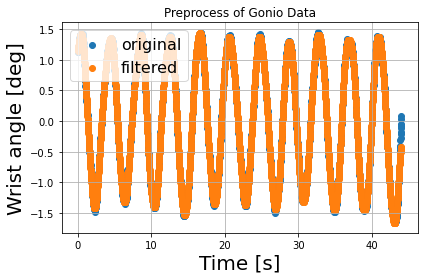

resampled_theta: 


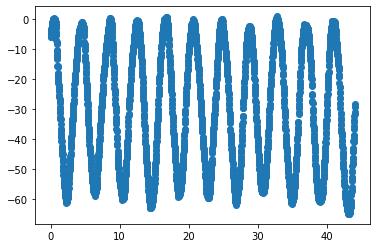

theta_zscore: 


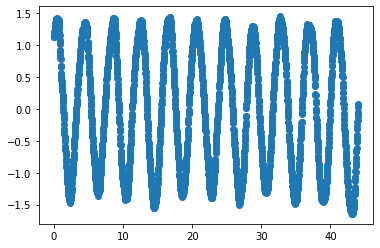

In [20]:
##### 図で確認

x = time
y1 = theta_before_low
y2 = theta_lowpass
print("x: ")
print(x.shape)
print("y1: ")
print(y1.shape)
print("y2: ")
print(y2.shape)

print("theta_before_low and theta_lowpass: ")
fig = plt.figure()
plt.title("Preprocess of Gonio Data")
plt.scatter(x, y1, label='original')
plt.scatter(x, y2, label='filtered')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

print("resampled_theta: ")
plt.scatter(time, resampled_theta, label='original')
plt.show()

print("theta_zscore: ")
plt.scatter(time, theta_zscore, label='normalized')
plt.show()

In [21]:
##### 処理データ・図の保存

theta = theta_lowpass

print("time: ")
print(time, time.shape)
print("theta: ")
print(theta, theta.shape)

# 前処理したゴニオデータを保存
with open(processed_theta_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Time", "Gonio"])
    for i in range(theta.shape[0]):
        writer.writerow([time[i], theta[i]])
    f.close()
    
# フィルターをかける前後のデータの比較グラフを保存
fig.savefig(gonio_comparison_path)


time: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
theta: 
[ 1.14192798  1.15469429  1.16764923 ... -0.43384303 -0.42566857
 -0.41879471] (2728,)


In [22]:


##############################     エコーデータの処理     ##############################



In [23]:
##### エコーデータ関連パス設定

print("Target Echo Data: " + echo_file)

# データ読み込み用パス
echo_path = data_path + "/EchoData"
target_echo_path = echo_path + "/" + echo_file
processed_movie_path = echo_path + "/ProcessedMovie/" + echo_file

# データ保存用パス
echo_processed_path = analysis_path + "/ProcessedData/EchoProcessed"
opticalflow_movie_path = echo_processed_path + "/OpticalflowMovie/" + echo_file
original_fp_path = echo_processed_path + "/OriginalFP/" + echo_file.split(".")[0] + ".csv"
processed_fp_path = echo_processed_path + "/ProcessedFP/" + echo_file.split(".")[0] + ".csv"
echo_comparison_path = echo_processed_path + "/EchoComparison/" + echo_file.split(".")[0] + ".png"


print("target_echo_path: " + str(target_echo_path))
print("processed_movie_path: " + str(processed_movie_path))
print("opticalflow_movie_path: " + str(opticalflow_movie_path))
print("original_fp_path: " + str(original_fp_path))
print("processed_fp_path: " + str(processed_fp_path))
print("echo_comparison_path: " + str(echo_comparison_path))

Target Echo Data: 20221108 133448.mp4
target_echo_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/EchoData/20221108 133448.mp4
processed_movie_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/EchoData/ProcessedMovie/20221108 133448.mp4
opticalflow_movie_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis1/ProcessedData/EchoProcessed/OpticalflowMovie/20221108 133448.mp4
original_fp_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis1/ProcessedData/EchoProcessed/OriginalFP/20221108 133448.csv
processed_fp_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis1/ProcessedData/EchoProcessed/ProcessedFP/20221108 133448.csv
echo_comparison_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis1/ProcessedData/EchoProcessed/EchoComparison/20221108 133448.png


In [24]:
##### 動画の前処理（実験データごとに最初の1回だけ実行する）
# 1. 動画時間を計測時間に合わせる（必要なフレーム数だけを保存）
# 2. 画像内の不要な部分を削る(スクリーン中のエコー部分のみ)


# processed_movie_pathが存在しない場合のみこのセルを実行
if not os.path.exists(processed_movie_path):
    
    # 動画取得
    video = cv2.VideoCapture(target_echo_path)

    # 動画情報
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS))   # 73, 62, 54, 48, or 43
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # フレームレート確認
    print("--Before Processing--")
    print("WIDTH: " + str(width) + ", HEIGHT: " + str(height))
    print("FRAME RATE: " + str(frame_rate) + ",\nFRAME COUNT: " + str(frame_count) + "\n")

    # 必要なフレームのみ取り出す
    start_frame = start_time * frame_rate # 876
    end_frame = end_time * frame_rate # 4088

    # 保存の準備
    fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    new_size = (right - left, bottom - top)
    save = cv2.VideoWriter(processed_movie_path, fmt, frame_rate, new_size)

    for i in range(end_frame):    # 1.の処理
        ret, frame = video.read()
        if ret == False:
            break
        if i < start_frame:
            continue

        frame = frame[top:bottom, left:right]   # 2.の処理
        frame = cv2.resize(frame, new_size)
        cv2.imshow("check frame", frame)
        key = cv2.waitKey(10)
        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
        save.write(frame)

    save.release()
    video.release()
    cv2.destroyAllWindows()

    processed_video = cv2.VideoCapture(processed_movie_path)
    # 動画情報
    width = int(processed_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(processed_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(processed_video.get(cv2.CAP_PROP_FPS))   # 73, 62, 54, 48, or 43
    frame_count = int(processed_video.get(cv2.CAP_PROP_FRAME_COUNT))
    processed_video.release()
    print("--After Processing--")
    print("WIDTH: " + str(width) + ", HEIGHT: " + str(height))
    print("FRAME RATE: " + str(frame_rate) + ",\nFRAME COUNT: " + str(frame_count) + "\n")

    print("Preprocessing is done")
else:
    print("Processed Movie already Exists")

Processed Movie already Exists


In [25]:
##### オプティカルフロー（解析ごとに最初の1回だけ実行する）

# opticalflow_movie_pathが存在しない場合のみこのセルを実行
if not os.path.exists(opticalflow_movie_path):
    
    # 動画取得
    video = cv2.VideoCapture(processed_movie_path)

    # Shi-Tomasi法のパラメータ（コーナー：物体の角を特徴点として検出）
    ft_params = dict(maxCorners=maxCorners,       # 特徴点の最大数
    qualityLevel=qualityLevel,    # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
    minDistance=minDistance,       # 特徴点間の最小距離
    blockSize=blockSize)         # 特徴点の計算に使うブロック（周辺領域）サイズ

    # Lucal-Kanade法のパラメータ（追跡用）
    lk_params = dict(winSize=(80,80),     # オプティカルフローの推定の計算に使う周辺領域サイズ
    maxLevel=4,          # ピラミッド数
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))       # 探索アルゴリズムの終了条件

    # # 動画情報
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS)) # 73, 62, 54, 48, or 43
    size = (width, height)  # (right - left, 560)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) # 3212
    print("FRAME COUNT: " + str(frame_count) + ",\nWIDTH: " + str(width) + ", HEIGHT: " + str(height) + "\n")

    # 最初のフレームを取得してグレースケール変換
    ret, frame = video.read()
    frame_pre = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 最初のフレームのみさらにトリミング
    frame_pre_first = frame_pre[trim_h : height - trim_h, trim_w : width - trim_w]

    # Shi-Tomasi法で特徴点の検出
    feature_pre = cv2.goodFeaturesToTrack(frame_pre_first, mask=None, **ft_params)

    # 座標をトリミング前のものに修正
    for v in feature_pre:
        v[0][0] += trim_w
        v[0][1] += trim_h

    # mask用の配列を生成
    mask = np.zeros_like(frame)

    frame_num = 0
    # 動画終了まで繰り返し
    while(video.isOpened() and frame_num < frame_count):

        # 次のフレームを取得し、グレースケールに変換
        ret, frame = video.read()
        if ret == False:
            break

        frame_now = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Lucas-Kanade法でフレーム間の特徴点のオプティカルフローを計算
        feature_now, status, err = cv2.calcOpticalFlowPyrLK(frame_pre, frame_now, feature_pre, None, **lk_params)

        # オプティカルフローを検出した特徴点を取得
        good1 = feature_pre[status == 1] # 1フレーム目
        good2 = feature_now[status == 1] # 2フレーム目

        # 座標を保存する配列を初期化、初期位置を保存
        if frame_num == 0:
            feature_points_of_all = np.empty([0, good1.shape[0], 2])
            feature_points_of_t = good1.reshape([1, good1.shape[0], 2])
            feature_points_of_all = np.append(feature_points_of_all, feature_points_of_t, axis=0)

            first_num = good1.shape[0]
            print("Num of feature point at first: " + str(first_num))

        # statusが0となるインデックスを取得
        vanish = np.where(status == 0)[0]

        # position_allからstatus=0の要素を削除
        for i, v in enumerate(vanish):
            # 最初のフレーム間で特徴点が消えている場合は何もしない
            if frame_num == 0:
                break
            feature_points_of_all = np.delete(feature_points_of_all, v - i, 1)

        # 各時刻における座標を保存
        feature_points_of_t = good2.reshape([1, good2.shape[0], 2])
        feature_points_of_all = np.append(feature_points_of_all, feature_points_of_t, axis=0)

        # 特徴点とオプティカルフローをフレーム・マスクに描画
        for i, (pt1, pt2) in enumerate(zip(good1, good2)):
            x1, y1 = pt1.ravel() # 1フレーム目の特徴点座標
            x2, y2 = pt2.ravel() # 2フレーム目の特徴点座標

            # 軌跡を描画（過去の軌跡も残すためにmaskに描く）
            mask = cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), [128, 128, 128], 1)

            # 現フレームにオプティカルフローを描画
            frame = cv2.circle(frame, (int(x2), int(y2)), 5, [0, 0, 200], -1)

        # フレームとマスクの論理積（合成）
        img = cv2.add(frame, mask)

        # ウィンドウに表示
        cv2.imshow('mask', img)

        # 次のフレーム、ポイントの準備
        frame_pre = frame_now.copy() # 次のフレームを最初のフレームに設定
        feature_pre = good2.reshape(-1, 1, 2) # 次の点を最初の点に設定

        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

        frame_num += 1

    last_num = good2.shape[0]
    print("Num of feature point at last: " + str(last_num) + "\n\n")

    # 終了処理
    cv2.destroyAllWindows()
    video.release()

    print("feature_points_of_all: ")
    print(feature_points_of_all, feature_points_of_all.shape)

else:
    print("Opticalflow Movie already exists.")

FRAME COUNT: 2728,
WIDTH: 1000, HEIGHT: 560

Num of feature point at first: 329
Num of feature point at last: 326


feature_points_of_all: 
[[[265.         160.        ]
  [644.         214.        ]
  [423.         226.        ]
  ...
  [265.         281.        ]
  [630.         298.        ]
  [329.         206.        ]]

 [[264.9541626  159.7220459 ]
  [643.8583374  213.91679382]
  [423.03039551 225.80325317]
  ...
  [264.96923828 280.87670898]
  [629.91052246 297.95367432]
  [328.85418701 205.74880981]]

 [[264.88009644 159.32495117]
  [643.81542969 213.82847595]
  [422.83877563 225.7199707 ]
  ...
  [265.09005737 280.57263184]
  [629.87738037 297.88140869]
  [328.84240723 205.44815063]]

 ...

 [[243.60235596 173.70054626]
  [642.2010498  212.66473389]
  [409.02493286 234.9979248 ]
  ...
  [237.10545349 282.67706299]
  [628.01928711 297.92416382]
  [321.55081177 210.23928833]]

 [[243.52786255 173.57304382]
  [642.24865723 212.73957825]
  [408.95236206 235.06387329]
  ...
  [236

In [26]:
##### （最後まで残ったすべての特徴点を動作の相関係数とともに保存する）
##### 最後まで残ったすべての特徴点を動作の相関係数が高いものから順に(50個)保存する

print("feature_points_of_all: " + str(feature_points_of_all.shape))

# 各特徴点の相関係数をリスト化
coef_list = list()
for i in range(feature_points_of_all.shape[1]):
    feature_point = feature_points_of_all[:, i, :]
    feature_point_x = feature_point[:, 0]
    feature_point_y = feature_point[:, 1]
    coef_x = np.corrcoef(theta.reshape(-1), feature_point_x)[0][1]
    coef_y = np.corrcoef(theta.reshape(-1), feature_point_y)[0][1]
    
    coef_list.append(max(coef_x, coef_y))
    
print("coef_list: " + str(len(coef_list)))
# print(coef_list)

# coef_listから相関係数の大きい順に並び変え，feature_num個だけ取り出す
selection_list = sorted(coef_list, reverse=True)[:feature_num]
print("selection_list: " + str(len(selection_list)))
print(selection_list)

# selection_listで取り出したものに該当する特徴点を選出する
selected_feature_points = np.empty([feature_points_of_all.shape[0], 0, 2])
print(selected_feature_points.shape)
for i in range(feature_points_of_all.shape[1]):
    feature_point = feature_points_of_all[:, i, :]
    feature_point_x = feature_point[:, 0]
    feature_point_y = feature_point[:, 1]
    coef_x = np.corrcoef(theta.reshape(-1), feature_point_x)[0][1]
    coef_y = np.corrcoef(theta.reshape(-1), feature_point_y)[0][1]
    
    if coef_x in selection_list or coef_y in selection_list:
#         print("index: " + str(i))
#         print("coef_x: " + str(coef_x) + ", coef_y: " + str(coef_y))
        feature_point_for_append = feature_point.reshape([feature_point.shape[0], 1, feature_point.shape[1]])
        selected_feature_points = np.append(selected_feature_points, feature_point_for_append, axis=1)

print("selected_feature_points: " + str(selected_feature_points.shape))

feature_points_of_all: (2728, 326, 2)
coef_list: 326
selection_list: 50
[0.693363018825786, 0.6883790525418905, 0.6840021441495072, 0.6836066296138109, 0.6741632221891719, 0.6520523216886228, 0.6516737616303427, 0.6461537538530618, 0.6183096219307042, 0.6058201593129753, 0.6021489197266064, 0.5827936211366519, 0.5727392387420855, 0.564689192388484, 0.5507360119277778, 0.5493577336582913, 0.5473953830875374, 0.5403957409629333, 0.5397409696387392, 0.537836772009302, 0.5292631901844235, 0.5280573355363654, 0.5206183938642591, 0.5188039429383883, 0.5180635286036089, 0.5108220904523436, 0.5088583539963331, 0.5006283787092976, 0.499735377727805, 0.49811175295665505, 0.4956848918273204, 0.49084429703622573, 0.48450473499415303, 0.4819175152920905, 0.47897709069839517, 0.4711125110641864, 0.46713990423730845, 0.4660212673988763, 0.4635474645619062, 0.4601660600591176, 0.4585163061409043, 0.4555933017308013, 0.4511056603531903, 0.4491572144255808, 0.4462078038985396, 0.44262203577682835, 0.439

In [27]:
##### 特徴点の選出・csvファイルへの保存（解析ごとに最初の1回だけ実行する）

# original_fp_pathが存在しない場合のみこのセルを実行
if not os.path.exists(original_fp_path):
    
#     # 特徴点を選出
#     feature_points_data = np.delete(feature_points_of_all, np.s_[feature_num:], 1) # (3212, 50, 2)
    # データの形を修正
    feature_points_data = selected_feature_points.reshape(
        [selected_feature_points.shape[0], selected_feature_points.shape[1] * 2]) # (3212, 100)
    print("feature_points_data: ")
    print(feature_points_data, feature_points_data.shape)

    # 特徴点データを保存
    with open(original_fp_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Feature Points Data"])
        for each_time_data in feature_points_data:
            writer.writerow(each_time_data)
        f.close()
    print("Save completed")

else:
    print("Original FP already exists.")

Original FP already exists.


EchoData: 20221108 133448.mp4
GonioData: 202211081334.csv
feature_points: 
[[265.         160.         644.         ... 227.         220.
  222.        ]
 [264.9541626  159.7220459  643.8583374  ... 226.81097412 220.04173279
  221.70248413]
 [264.88009644 159.32495117 643.81542969 ... 226.70869446 220.26293945
  221.36904907]
 ...
 [243.60235596 173.70054626 642.2010498  ... 235.00178528 222.06169128
  230.86068726]
 [243.52786255 173.57304382 642.24865723 ... 235.02516174 222.06767273
  230.8228302 ]
 [243.4410553  173.31242371 642.24768066 ... 235.03369141 221.84698486
  230.77268982]] (2728, 100)
theta: 
[ 1.14192798  1.15469429  1.16764923 ... -0.43384303 -0.42566857
 -0.41879471] (2728,)


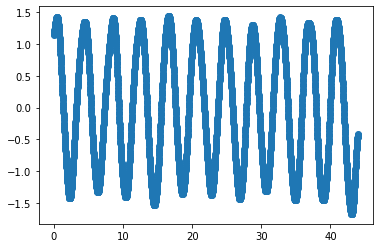

In [28]:
##### 特徴点データとゴニオデータの読み込み
# 要修正　特徴点選出の前に
# フォルダごと　selected_FPを追加する

print("EchoData: " + echo_file)
print("GonioData: " + gonio_file)

with open(original_fp_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    feature_points = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        feature_points.append(row)
    f.close()

# with open(processed_theta_path, encoding="utf-8") as f:
#     reader = csv.reader(f)
#     theta = list()
#     for i, row in enumerate(reader):
#         if i == 0:
#             continue
#         theta.append(row[1])
#     f.close()

feature_points = np.array(feature_points).astype(float)[:, :]
# theta = np.array(theta).astype(float)[:]

print("feature_points: ")
print(feature_points, feature_points.shape)
print("theta: ")
print(theta, theta.shape)


plt.scatter(time, theta)
plt.show()

In [29]:
##### 選出した特徴点の描画・動画保存（解析ごとに最初の1回だけ実行する）

# opticalflow_movie_pathが存在しない場合のみこのセルを実行
if not os.path.exists(opticalflow_movie_path):
    
    # 特徴点データを元の形に直す（1つの特徴点につきx,y座長の2データを持つ）
    feature_points = feature_points.reshape([feature_points.shape[0], feature_num, 2]) # (3212, 50, 2)
    print("feature_points: ")
    print(feature_points, feature_points.shape)

    # 動画取得
    video = cv2.VideoCapture(processed_movie_path)

    # 動画情報
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    size = (width, height)  # (right - left, 560)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS))
    print("FRAME COUNT: " + str(frame_count) + ",\nWIDTH: " + str(width) + ", HEIGHT: " + str(height) + "\n")

    # 保存の準備
    fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    save = cv2.VideoWriter(opticalflow_movie_path, fmt, frame_rate, size)

    # 最初のフレームを取得
    ret, frame = video.read()

    # mask用の配列を生成
    mask = np.zeros_like(frame)

    # 最初の特徴点の座標を取得
    points_pre = feature_points[0] # (50, 2)

    # 動画終了まで繰り返し
    for t in range(feature_points.shape[0] - 1):

        # 現在のフレームを取得
        ret, frame = video.read()
        if ret == False:
            print("false t: " + str(t))
            break

        # 現在の特徴点の座標を取得
        points_now = feature_points[t+1]

        # 現在の関節角度を取得
        theta_now = round(theta[t], 2)

        # オプティカルフローと現在の特徴点をmask, frameに描画
        for p_pre, p_now in zip(points_pre, points_now):
            x1, y1 = p_pre[0], p_pre[1]
            x2, y2 = p_now[0], p_now[1]

            mask = cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), [128, 128, 128], 1)
            frame = cv2.circle(frame, (int(x2), int(y2)), 5, [0, 0, 200], -1)

            # 関節角度情報を描画
            angle = "Wrist Angle: " + str(theta_now)
            # org = (20, 460) # 挿入する座標
            cv2.putText(frame, angle, wrist_angle_position, fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5, color=(255, 255, 255))

        # frameとmaskの合成
        img = cv2.add(frame, mask)

        # ウィンドウに表示
        cv2.imshow("mask", img)

        # フレームごとに保存
        save.write(img)

        # 特徴点の更新
        points_pre = points_now

        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    # 終了処理
    cv2.destroyAllWindows()
    video.release()
    save.release()

    print("Save completed")
    
    # 特徴点データを解析用の形に戻す
    feature_points = feature_points.reshape([feature_points.shape[0], feature_num * 2]) # (3212, 100)

else:
    print("Opticalflow Mivie already exists.")

feature_points: 
[[[265.         160.        ]
  [644.         214.        ]
  [423.         226.        ]
  ...
  [630.         206.        ]
  [395.         227.        ]
  [220.         222.        ]]

 [[264.9541626  159.7220459 ]
  [643.8583374  213.91679382]
  [423.03039551 225.80325317]
  ...
  [629.86358643 205.92347717]
  [395.02368164 226.81097412]
  [220.04173279 221.70248413]]

 [[264.88009644 159.32495117]
  [643.81542969 213.82847595]
  [422.83877563 225.7199707 ]
  ...
  [629.91015625 205.81837463]
  [394.99404907 226.70869446]
  [220.26293945 221.36904907]]

 ...

 [[243.60235596 173.70054626]
  [642.2010498  212.66473389]
  [409.02493286 234.9979248 ]
  ...
  [622.56488037 204.60676575]
  [382.20016479 235.00178528]
  [222.06169128 230.86068726]]

 [[243.52786255 173.57304382]
  [642.24865723 212.73957825]
  [408.95236206 235.06387329]
  ...
  [622.69134521 204.65818787]
  [382.12298584 235.02516174]
  [222.06767273 230.8228302 ]]

 [[243.4410553  173.31242371]
  [642.

EchoData: 20221108 133448.mp4

--Before Processing--
feature_points: 
[[265.         160.         644.         ... 227.         220.
  222.        ]
 [264.9541626  159.7220459  643.8583374  ... 226.81097412 220.04173279
  221.70248413]
 [264.88009644 159.32495117 643.81542969 ... 226.70869446 220.26293945
  221.36904907]
 ...
 [243.60235596 173.70054626 642.2010498  ... 235.00178528 222.06169128
  230.86068726]
 [243.52786255 173.57304382 642.24865723 ... 235.02516174 222.06767273
  230.8228302 ]
 [243.4410553  173.31242371 642.24768066 ... 235.03369141 221.84698486
  230.77268982]] (2728, 100)


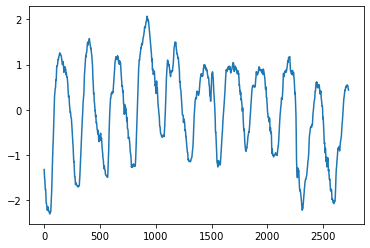

(2728, 100)
(2728,)

--After Processing--
processed_feature_points: 
[[ 0.75686766 -0.23755374  1.0175155  ... -1.85912451  0.90651081
  -1.31855165]
 [ 0.75227041 -0.26811039  0.97707991 ... -1.92436604  0.91562413
  -1.37807707]
 [ 0.74484197 -0.31176466  0.96483251 ... -1.95966746  0.96392973
  -1.44478902]
 ...
 [-1.38920379  1.26860422  0.50403052 ...  0.9026601   1.35672888
   0.45424836]
 [-1.39667509  1.25458735  0.51761938 ...  0.91072839  1.35803507
   0.44667412]
 [-1.4053814   1.2259363   0.51734064 ...  0.91367237  1.30984276
   0.43664229]] (2728, 100)
x: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
y1: 
[ 0.75686766  0.75227041  0.74484197 ... -1.38920379 -1.39667509
 -1.4053814 ] (2728,)
y2: 
[ 0.75686766  0.75227041  0.74484197 ... -1.38920379 -1.39667509
 -1.4053814 ] (2728,)


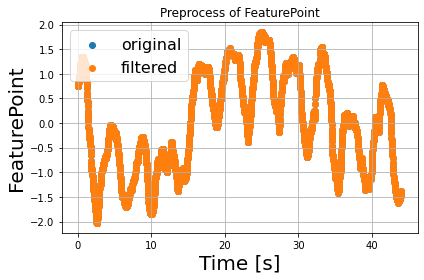

Save completed


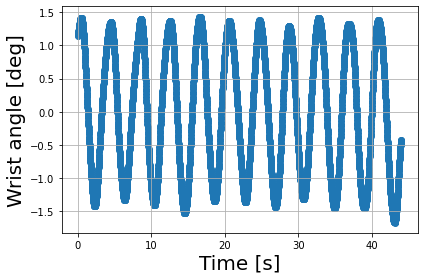

In [30]:
##### 特徴点データの処理・保存
print("EchoData: " + echo_file)

print("\n--Before Processing--")
print("feature_points: ")
print(feature_points, feature_points.shape)


# 正規化
select_normalize_position = 2
#1:正規化しない、2:正規化する

if select_normalize_position==1:
    processed_feature_points = feature_points

if select_normalize_position==2:
   
    data_fp = feature_points
    processed_feature_points = feature_points

    #NumPyで配列の正規化(normalize)、標準化する方法
    #https://deepage.net/features/numpy-normalize.html
    import numpy as np
    def zscore(x, axis = None):
        xmean = x.mean(axis=axis, keepdims=True)
        xstd  = np.std(x, axis=axis, keepdims=True)
        zscore = (x-xmean)/xstd
        return zscore, xmean, xstd

    #すべての特徴点の正規化
    for i in range(data_fp.shape[1]):
        fp_part,fp_mean,fp_std = zscore(data_fp[:,i])
        processed_feature_points[:,i] = fp_part

    plt.plot(fp_part)
    plt.show()

    print('===============')
    print(feature_points.shape)
    print(fp_part.shape)
    print('===============')
    

# ローパスフィルタ
#フィルター選択(角度情報)
#1: raw, 2:lowpath
filter_select = 1

#ローパス
samplerate = 30
fp_l = 0.5 # 通過域端周波数[Hz] #フーリエ変換にあわせて調整
fs_l = 2.5 # 阻止域端周波数[Hz] # fp*5くらい
gpass_l = 3 # 通過域端最大損失[dB]
gstop_l = 40 # 阻止域端最小損失[dB]
from scipy import signal
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y  

if filter_select == 2:
    for i in range(data_fp.shape[1]):
        fp_part,fp_mean,fp_std = zscore(processed_feature_points[:,i])
        fp_part_low = lowpass(fp_part, samplerate, fp_l, fs_l, gpass_l, gstop_l)
        plt.scatter(time,fp_part_low,s=5)

        processed_feature_points[:,i] = fp_part_low


# 特徴点データを保存
with open(processed_fp_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Processed Feature Points Data"])
    for each_time_data in processed_feature_points:
        writer.writerow(each_time_data)
    f.close()
    

print("\n--After Processing--")
print("processed_feature_points: ")
print(processed_feature_points, processed_feature_points.shape)


# 比較グラフの表示・保存（Noつ目の特徴点のみ）

No = 0
x = time
y1 = feature_points[:, No]
y2 = processed_feature_points[:, No]

print("x: ")
print(x, x.shape)
print("y1: ")
print(y1, y1.shape)
print("y2: ")
print(y2, y2.shape)

fig = plt.figure()
plt.title("Preprocess of FeaturePoint")
plt.scatter(x, y1, label='original')
plt.scatter(x, y2, label='filtered')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("FeaturePoint", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
fig.savefig(echo_comparison_path)

print("Save completed")

plt.scatter(time, theta)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:


##############################     解析     ##############################



In [32]:
##### 結果保存用パス設定

point_behavior = analysis_path + "/Results/PointBehavior/" + gonio_file.split(".")[0]
angle_estimation = analysis_path + "/Results/AngleEstimation/" + gonio_file.split(".")[0]
each_datasheet_path = analysis_path + "/Results/each_datasheet.csv"

print("point_behavior: " + str(point_behavior))
print("angle_estimation: " + str(angle_estimation))
print("each_datasheet_path: " + str(each_datasheet_path))

point_behavior: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis1/Results/PointBehavior/202211081334
angle_estimation: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis1/Results/AngleEstimation/202211081334
each_datasheet_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221108_Katagi_/Analysis1/Results/each_datasheet.csv


In [33]:
##### データ読み込み

print("EchoData : " + echo_file)
print("GonioData: " + gonio_file)

with open(processed_fp_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    X = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        X.append(row)
    f.close()
# with open(processed_theta_path, encoding="utf-8") as f:
#     reader = csv.reader(f)
#     theta = list()
#     for i, row in enumerate(reader):
#         if i == 0:
#             continue
#         theta.append(row[1])
#     f.close()

X = np.array(X).astype(float)[:, :]
theta = np.array(theta).astype(float)[:, np.newaxis]

print("X: ")
print(X, X.shape)
print("theta: ")
print(theta, theta.shape)

EchoData : 20221108 133448.mp4
GonioData: 202211081334.csv
X: 
[[ 0.75686766 -0.23755374  1.0175155  ... -1.85912451  0.90651081
  -1.31855165]
 [ 0.75227041 -0.26811039  0.97707991 ... -1.92436604  0.91562413
  -1.37807707]
 [ 0.74484197 -0.31176466  0.96483251 ... -1.95966746  0.96392973
  -1.44478902]
 ...
 [-1.38920379  1.26860422  0.50403052 ...  0.9026601   1.35672888
   0.45424836]
 [-1.39667509  1.25458735  0.51761938 ...  0.91072839  1.35803507
   0.44667412]
 [-1.4053814   1.2259363   0.51734064 ...  0.91367237  1.30984276
   0.43664229]] (2728, 100)
theta: 
[[ 1.14192798]
 [ 1.15469429]
 [ 1.16764923]
 ...
 [-0.43384303]
 [-0.42566857]
 [-0.41879471]] (2728, 1)


In [34]:
##### 学習データ・テストデータの分割

# 訓練データとテストデータの区切り位置
devide_num = X.shape[0] * 4 // 5

print(devide_num)

X_train = X[:devide_num]
theta_train = theta[:devide_num]

print("devide_num: " + str(devide_num))
print("X_train: ")
print(X_train, X_train.shape)
print("theta_train: ")
print(theta_train, theta_train.shape)

2182
devide_num: 2182
X_train: 
[[ 0.75686766 -0.23755374  1.0175155  ... -1.85912451  0.90651081
  -1.31855165]
 [ 0.75227041 -0.26811039  0.97707991 ... -1.92436604  0.91562413
  -1.37807707]
 [ 0.74484197 -0.31176466  0.96483251 ... -1.95966746  0.96392973
  -1.44478902]
 ...
 [-1.14355235  1.12173571  0.86065119 ...  0.62796416 -0.32057875
   0.98658232]
 [-1.13659526  1.15125233  0.87777665 ...  0.63470529 -0.34156105
   1.02121441]
 [-1.13460118  1.18467912  0.84633061 ...  0.6480243  -0.36057073
   1.0565395 ]] (2182, 100)
theta_train: 
[[ 1.14192798]
 [ 1.15469429]
 [ 1.16764923]
 ...
 [-1.3385923 ]
 [-1.32360311]
 [-1.30773613]] (2182, 1)


In [35]:
##### 重みの導出

#最小事情法で正則化するか
#1:正則化なし、2:正則化あり
regularize_select = 2

X_T = X_train.T
X_T_X = np.dot(X_T, X_train)
I = np.eye(X_T_X.shape[0])

if regularize_select==1:
    inv = np.linalg.pinv(X_T_X)

if regularize_select==2:
    inv = np.linalg.pinv(X_T_X + lam * I)

W = np.dot(np.dot(inv, X_T), theta_train)

W_reshape = W.reshape(-1)
W_max_index = np.argmax(W_reshape)
W_max = np.max(W_reshape)
W_min_index = np.argmin(W_reshape)
W_min = np.min(W_reshape)

print("X_T: " + str(X_T.shape))
print("X_T_X: " + str(X_T_X.shape))
print("inv: " + str(inv.shape))
print("W: " + str(W.shape))
# print(W)
print("W_max: ")
print("index: " + str(W_max_index) + " value: " + str(W_max))
print("W_min: ")
print("index: " + str(W_min_index) + " value: " + str(W_min))

X_T: (100, 2182)
X_T_X: (100, 100)
inv: (100, 100)
W: (100, 1)
W_max: 
index: 14 value: 0.6261473690108044
W_min: 
index: 79 value: -0.7827090216363839


angle: 
(2728,)
X_max: 
(2728,)
X_min: 
(2728,)


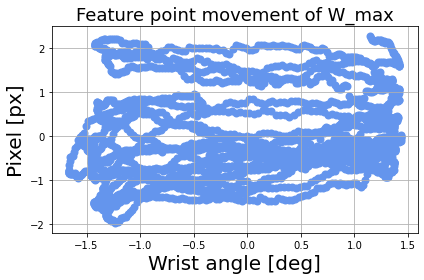

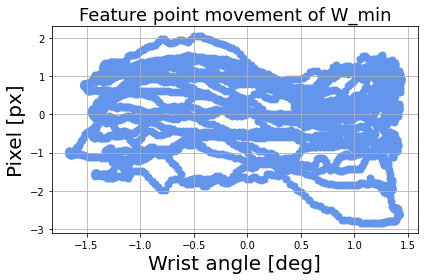

Save completed


In [36]:
##### 関節角度-特徴点座標のグラフを作成・保存

angle = theta.reshape(-1)
# 重みが最大・最小となっている特徴点のみ取り出す
X_max = X[:, W_max_index]
X_min = X[:, W_min_index]

print("angle: ")
print(angle.shape)
print("X_max: ")
print(X_max.shape)
print("X_min: ")
print(X_min.shape)

def Visualize(x, y, save_path, max_or_min):
    fig = plt.figure()
    plt.title("Feature point movement of W_" + max_or_min, fontsize=18)
    plt.xlabel("Wrist angle [deg]", fontsize=20)
    plt.ylabel("Pixel [px]", fontsize=20)
    plt.scatter(x, y, color="cornflowerblue", linewidth=2, label="Feature Point Movement")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    fig.savefig(save_path + max_or_min + ".png")
    plt.close()

Visualize(angle, X_max, point_behavior, "max")
Visualize(angle, X_min, point_behavior, "min")

print("Save completed")

In [37]:
##### 関節角度の推定値を導出

theta_pred = np.dot(X, W)

print("theta_pred: ")
print(theta_pred, theta_pred.shape)

theta_pred: 
[[1.11506513]
 [1.07427164]
 [1.09428568]
 ...
 [0.46152024]
 [0.48693929]
 [0.51854623]] (2728, 1)


x: 
[0.00000000e+00 1.61349468e-02 3.22698937e-02 ... 4.39677301e+01
 4.39838651e+01 4.40000000e+01] (2728,)
y1: 
[ 1.14192798  1.15469429  1.16764923 ... -0.43384303 -0.42566857
 -0.41879471] (2728,)
y2: 
[1.11506513 1.07427164 1.09428568 ... 0.46152024 0.48693929 0.51854623] (2728,)


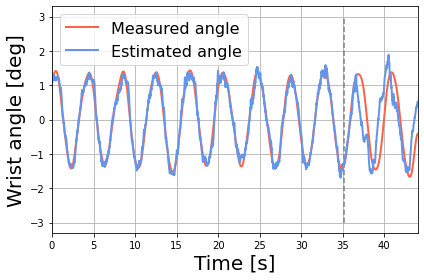

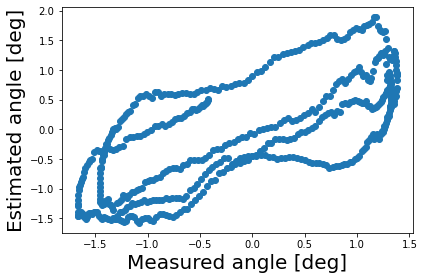

In [38]:
##### グラフ作成・保存

x = time
y1 = theta.reshape(-1)
y2 = theta_pred.reshape(-1)

print("x: ")
print(x, x.shape)
print("y1: ")
print(y1, y1.shape)
print("y2: ")
print(y2, y2.shape)

fig1 = plt.figure()
# plt.title("A result of estimating wrist joint angle", fontsize=18)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.plot(x, y1, color="tomato", linewidth=2, label="Measured angle")
plt.plot(x, y2, color="cornflowerblue", linewidth=2, label="Estimated angle")
line_position = devide_num / echo_frame_rate

#plt.vlines(line_position, min_height, max_height, "gray", linestyles="dashed")
plt.vlines(line_position, -3, 3, "gray", linestyles="dashed")

#plt.ylim(min_height, max_height) #extensor

plt.xlim(0, x.shape[0] / echo_frame_rate)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
fig1.savefig(angle_estimation + "_estimation.png")

fig2 = plt.figure()
# plt.title("Scatter plots of estimated and measured angle", fontsize=16)
plt.xlabel("Measured angle [deg]", fontsize=20)
plt.ylabel("Estimated angle [deg]", fontsize=20)
plt.scatter(y1[devide_num:], y2[devide_num:])
plt.tight_layout()
fig2.savefig(angle_estimation + "_scatter.png")

plt.show()
plt.close()

In [39]:
##### RMSE，決定係数R2，相関係数coeffを導出

theta_test = theta.reshape(-1)[devide_num:]
theta_pred_test = theta_pred.reshape(-1)[devide_num:]

T = theta_test.shape[0]
L = np.sum((theta_test - theta_pred_test)**2)
RMSE = np.sqrt(L/T)


if select_normarize_joint == 2:
    RMSE = float(theta_std*RMSE)

R2 = r2_score(theta_test, theta_pred_test)

coef = np.corrcoef(theta_test, theta_pred_test)[0][1]

print("theta_test: ")
print(theta_test.shape)
print("theta_pred_test: ")
print(theta_pred_test.shape)
print("T: " + str(T))
print("L: " + str(L))
print("RMSE: " + str(RMSE))
    
print("決定係数 R2: " + str(R2))
print("相関係数: " + str(coef) + "\n")

theta_test: 
(546,)
theta_pred_test: 
(546,)
T: 546
L: 301.0751146634292
RMSE: 15.838107031472298
決定係数 R2: 0.489836692504225
相関係数: 0.7161955978814877



In [40]:
# ##### 結果の保存

# # データシートへの保存
# f = open(datasheet_path, "r")
# datasheet_all = csv.reader(f)
# datasheet_list = [e for e in datasheet_all]
# f.close()

# flag = True
# for row in datasheet_list:
#     # 該当する行の結果を更新
#     if row[0] == str(data_No) and row[1] == date and row[2] == subject and row[3] == str(pattern) \
#         and row[4] == additional_info and row[5] == modified_info and row[6] == str(trial_num) \
#         and row[8] == str(depth) and row[9] == str(gain) and row[10] == focus and row[11] == str(frequency) and row[12] == str(dynamic_range) \
#         and row[14] == gonio_file and row[15] == echo_file:
#             row[17], row[18], row[19] = RMSE, R2, coef
#             flag = False
            
# # # 同じ条件のものがなければ，一番下の列に追加
# print("flag: " + str(flag))
# # if flag:
# #     datasheet_list.append([data_No, date, subject, pattern, additional_info, modified_info, trial_num, "", 
# #                            depth, gain, focus, frequency, dynamic_range, "", 
# #                            gonio_file, echo_file, "", RMSE, R2, coef])

# with open(datasheet_path, "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(datasheet_list)
#     f.close()


# f = open(each_datasheet_path, "r")
# each_datasheet_all = csv.reader(f)
# each_datasheet_list = [e for e in each_datasheet_all]
# f.close()

# flag = True
# for row in each_datasheet_list:
#     # 同じ条件で一度結果を出していれば，その列の結果の値のみを変更
#     if row[0] == data_No and row[1] == date and row[2] == subject and row[3] == str(pattern) \
#         and row[4] == additional_info and row[5] == modified_info and row[6] == str(trial_num) \
#         and row[8] == str(depth) and row[9] == str(gain) and row[10] == focus and row[11] == str(frequency) and row[12] == str(dynamic_range) \
#         and row[14] == gonio_file and row[15] == echo_file:
#             row[17], row[18], row[19] = RMSE, R2, coef
#             flag = False
# # 同じ条件のものがなければ，一番下の列に追加
# print("flag: " + str(flag))
# if flag:
#     each_datasheet_list.append([data_No, date, subject, pattern, additional_info, trial_num, "", 
#                            depth, gain, focus, frequency, dynamic_range, "", 
#                            gonio_file, echo_file, "", RMSE, R2, coef])



# with open(each_datasheet_path, "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(each_datasheet_list)
#     f.close()

# print("Save completed")

In [42]:
##### 結果の保存

target_data.loc[:, ["RMSE"]] = RMSE
target_data.loc[:, ["R2"]] = R2
target_data.loc[:, ["Corrcoef"]] = coef

print(target_data.loc[:, ["RMSE"]])
print(target_data.loc[:, ["R2"]])
print(target_data.loc[:, ["Corrcoef"]])

# 全データのデータフレームを更新
data_sheet.update(target_data)

# 全データのデータシートに記入
data_sheet.to_csv(datasheet_path, encoding="shift_jis", index=False)



# target_data["RMSE"].iloc[0] = RMSE
# target_data["R2"].iloc[0] = R2
# target_data["Corrcoef"].iloc[0] = coef

# print("RMSE: " + str(target_data["RMSE"].iloc[0]))
# print("R2: " + str(target_data["R2"].iloc[0]))
# print("Corrcoef: " + str(target_data["Corrcoef"].iloc[0]))

# # 全データのデータシートに記入
# data_sheet[ data_sheet['No']==data_No ] = target_data
# data_sheet.to_csv(datasheet_path, encoding="shift_jis", index=False)

# # # 各解析ごとのデータシートに記入
# # each_datasheet = pd.read_csv(each_datasheet_path, header=0, encoding='shift_jis')
# # each_datasheet[ each_datasheet["Trial Num"]==trial_num ] = target_data
# # each_datasheet.to_csv(each_datasheet_path, encoding="shift_jis", index=False)

# # print(target_data)

print("Save completed")

        RMSE
0  15.838107
         R2
0  0.489837
   Corrcoef
0  0.716196
Save completed
